<h1><center>YOLO Intelligent Vision: Menciptakan Solusi Multifungsi untuk Deteksi Objek Kendaraan dengan Deep Learning</center></h1>
<h3><center>Kelompok 2</center></h3>
<h5><center>Proyek ini membawa konsep deteksi objek kendaraan menggunakan YOLO ke tingkat berikutnya dengan fokus pada solusi multifungsi.</center></h5>

# Latar Belakang
Projek ini dilatarbelakangi kebutuhan untuk mengembangkan sistem deteksi kendaraan yang efisien dan akurat. Penerapan YOLO sebagai model machine learning untuk tugas ini dipilih karena kemampuannya dalam mendeteksi objek dalam waktu nyata dengan tingkat akurasi yang baik. Dengan adanya peningkatan jumlah kendaraan di jalan, deteksi otomatis dapat memberikan kontribusi positif terhadap pemantauan lalu lintas, keamanan, dan analisis data transportasi.

# Tujuan
Mengimplementasikan model machine learning menggunakan YOLO untuk mendeteksi kendaraan dalam video dengan fokus akurasi dan kecepatan deteksi.

# Manfaat
- Membuat statistik mengenai kepadatan suatu rute perjalanan.
- Mengetahui tingkat keramaian pada suatu titik jalan.
- Mengetahui kecenderungan orang berpergian pada ruas jalan tertentu.

# Sekilas Mengenai Dataset yang Digunakan

Author : Ashfak Yeafi <br>
Link : https://www.kaggle.com/datasets/ashfakyeafi/road-vehicle-images-dataset

### Konten
Dataset ini berisikan kendaraan di jalanan Bangladesh dan anotasinya. Terdapat dua folder di dataset ini, satu berisikan train image dan satunya berisi validation image. <br>
Dataset ini memiliki 3004 gambar yang sudah diberi anotasi atau label dan .yaml file yang mengandung class label yang digunakan.

### Rincian Class pada Dataset:

| No. | Class                 | Train | Valid | Total |
|-----|-----------------------|-------|-------|-------|
| 1   | ambulance             | 372   | 0     | 372   |
| 2   | army vehicle          | 70    | 0     | 70    |
| 3   | auto rickshaw         | 43    | 0     | 43    |
| 4   | bicycle               | 427   | 32    | 459   |
| 5   | bus                   | 2909  | 423   | 3332  |
| 6   | car                   | 4632  | 842   | 5474  |
| 7   | garbagevan            | 3     | 0     | 3     |
| 8   | human hauler          | 169   | 0     | 169   |
| 9   | minibus               | 93    | 2     | 95    |
| 10  | minivan               | 822   | 109   | 931   |
| 11  | motorbike             | 1949  | 335   | 2284  |
| 12  | pickup                | 1083  | 142   | 1225  |
| 13  | policecar             | 31    | 1     | 32    |
| 14  | rickshaw              | 3336  | 203   | 3539  |
| 15  | scooter               | 37    | 1     | 38    |
| 16  | suv                   | 798   | 60    | 858   |
| 17  | taxi                  | 41    | 19    | 60    |
| 18  | three wheelers -CNG-  | 2734  | 252   | 2986  |
| 19  | truck                 | 1411  | 84    | 1495  |
| 20  | van                   | 693   | 62    | 755   |

<p align="center">
  <img height=500 height=auto src="asset\class_plot.png">
</p>


# Gambaran besar projek ini
1. Pencarian dataset
2. Dataset yang telah ditemukan akan ditrain berdasarkan YOLOv5xu model
3. YOLOv5xu yang telah ditrain dengan dataset sudah siap diaplikasikan 
   
<div align="center">
  <img src="asset\alur.png">
</div>

### Folder path
```python
.
├── asset/ ➜ asset yang digunakan pada notebook ini (gambar)
├── asset_penerapan/ ➜ asset yang digunakan untuk demo penerapan model
│   ├── compress/ ➜ hasil yang sudah dikompress agar dapat ditampilkan & diupload ke github
│   ├── result/ ➜ hasil predict
│   └── source/ ➜ asset yang akan dipredict
├── runs/
│   └── detect/
│       └── train/
│           └── weight/
│               └── best.pt ➜ hasil training
├── source/
├── trafic_data/ ➜ dataset yang digunakan
│   ├── train/ ➜ dataset untuk train
│   │   ├── images/
│   │   └── labels/
│   ├── valid/ ➜ dataset untuk tes kevalidan
│   │   ├── images/
│   │   └── labels/
│   └── data_1.yaml ➜ .yaml file dataset
├── wandb/ ➜ dibuat otomatis untuk menyimpan file wandb secara lokal
└── main.ipynb
```

# Projek

## Inisiasi Awal

In [1]:
import os
import random
import yaml

from ultralytics import YOLO
import cv2

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math

In [2]:
train_images = "trafic_data/train/images"
train_labels = "trafic_data/train/labels"

## Image Labelling
Untuk melakukan labelling dapat menggunakan berbagai tool seperti https://roboflow.com/, https://github.com/HumanSignal/labelImg, https://github.com/HumanSignal/label-studio <br>
karena data yang kami gunakan sudah diberi label maka kami tidak perlu melakukan tahapan ini lagi.


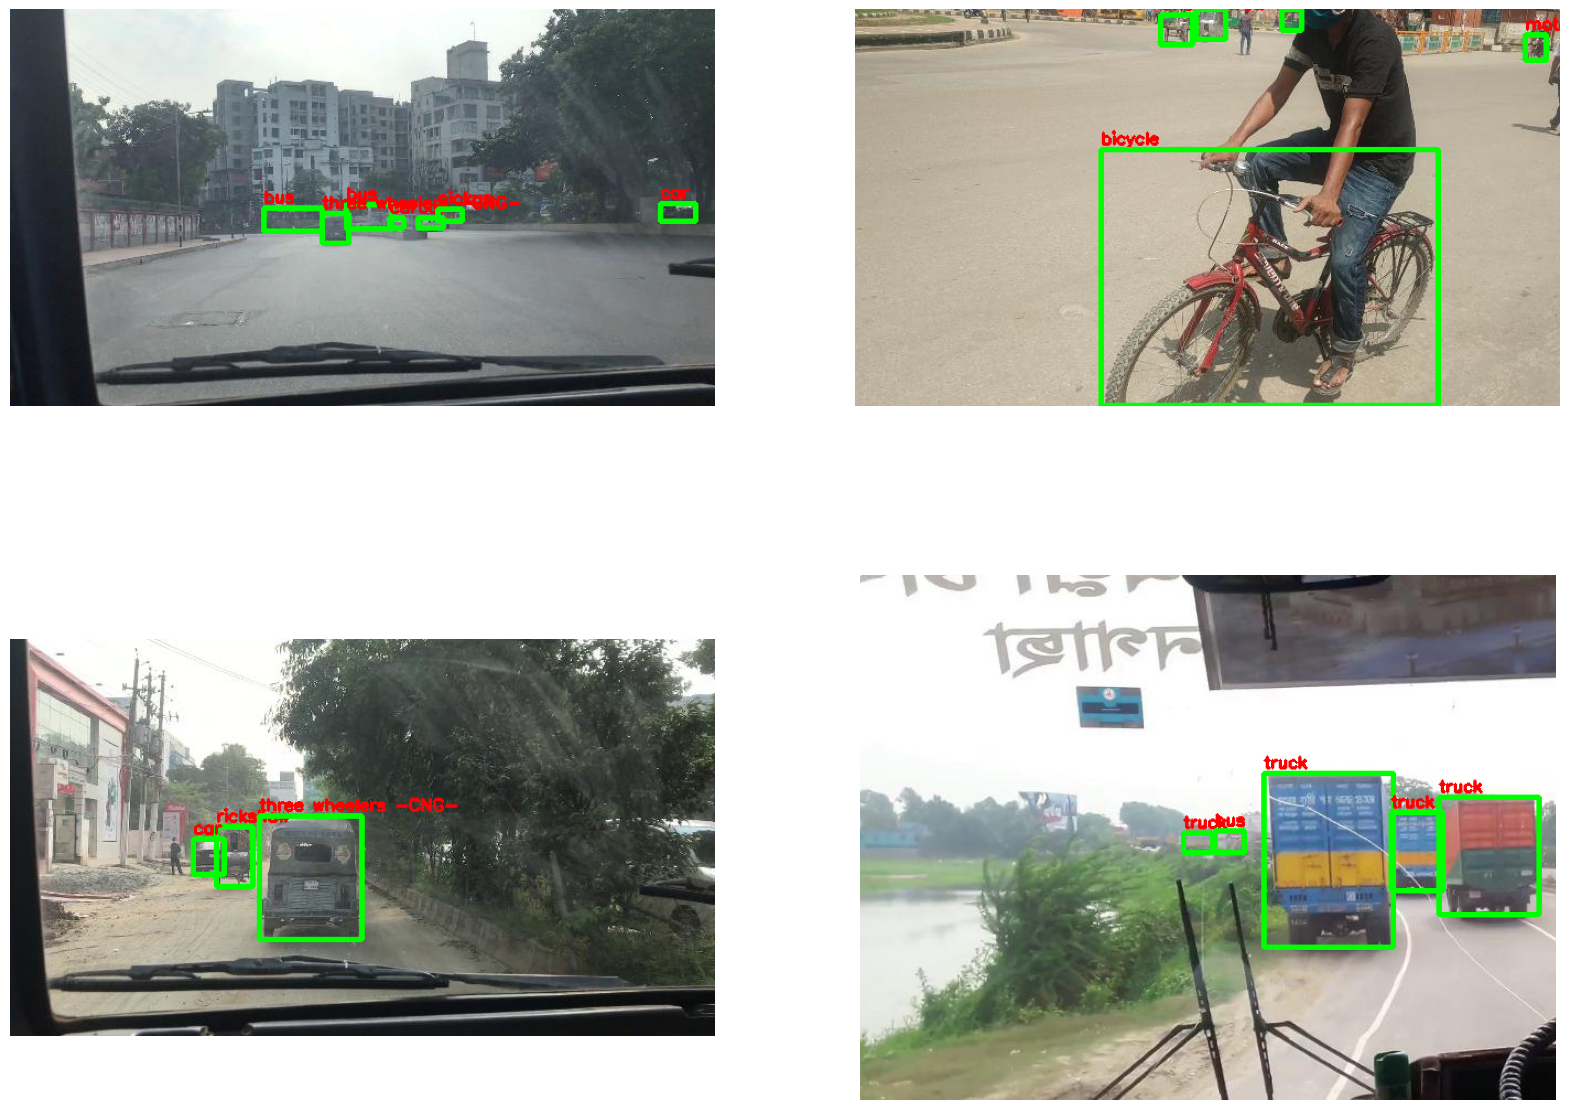

In [3]:
def load_labels(image_file, train_labels):
    label_file = os.path.splitext(image_file)[0] + ".txt"
    label_path = os.path.join(train_labels, label_file)
    
    with open(label_path, "r") as f:
        labels = f.read().strip().split("\n")
    
    return labels

def plot_object_detections(ax, image, labels, label_names):
    for label in labels:
        if len(label.split()) != 5:
            continue
        
        class_id, x_center, y_center, width, height = map(float, label.split())
        x_min = int((x_center - width/2) * image.shape[1])
        y_min = int((y_center - height/2) * image.shape[0])
        x_max = int((x_center + width/2) * image.shape[1])
        y_max = int((y_center + height/2) * image.shape[0])

        label_name = label_names['names'][int(class_id)]
        label_text = f"{label_name}"
        
        cv2.putText(image, label_text, (x_min, y_min - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 3)

    ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    ax.axis('off')

def load_label_names(yaml_path):
    with open(yaml_path, 'r') as file:
        label_names = yaml.safe_load(file)
    return label_names

train_images = "trafic_data/train/images"
train_labels = "trafic_data/train/labels"
image_files = os.listdir(train_images)
random_images = random.sample(image_files, 4)
label_names = load_label_names("trafic_data/data_1.yaml")

num_columns = 2
num_images = len(random_images)
num_rows = math.ceil(num_images / num_columns)

fig, axs = plt.subplots(num_rows, num_columns, figsize=(20, 15))

for i, image_file in enumerate(random_images):
    row, col = divmod(i, num_columns)
    
    # Load the image
    image_path = os.path.join(train_images, image_file)
    image = cv2.imread(image_path)

    # Load the labels for this image
    labels = load_labels(image_file, train_labels)

    # Plot object detections with label names
    plot_object_detections(axs[row, col], image, labels, label_names)

plt.show()


## Informasi Dataset

### Nama class yang digunakan

In [52]:
with open('trafic_data/data_1.yaml', 'r') as f:
    data = f.read()

print(data)

train: trafic_data/train/images
val: trafic_data/valid/images

nc: 21
names: ['ambulance', 'army vehicle', 'auto rickshaw', 'bicycle', 'bus', 'car', 
        'garbagevan', 'human hauler', 'minibus', 'minivan', 'motorbike', 'pickup', 
        'policecar', 'rickshaw', 'scooter', 'suv', 'taxi', 'three wheelers -CNG-', 
        'truck', 'van', 'wheelbarrow']


### Dimensi gambar dataset

In [5]:
h, w, c = image.shape

print(f"The image has dimensions {w}x{h} and {c} channels.")

The image has dimensions 640x483 and 3 channels.


## Train Model

### Sekilas proses trainingnya :
Device : 
- Ram 16 gb
- RTX 3050 Laptop 4gb

Waktu menyelesaikan 30 epochs : ± 6 jam 5 menit (CUDA)


In [1]:
# Mengaktifkan CUDA yang berfungsi untuk mempercepat deep learning dengan memanfaatkan gpu NVIDIA
import torch

device = "0" if torch.cuda.is_available() else "cpu"
if device == "0":
    torch.cuda.set_device(0)

print(device)    

0


In [ ]:
# Inisialisasi model YOLO menggunakan pre-trained weights dari file 'yolov5xu.pt'
model = YOLO('yolov5xu.pt')

# - data: Lokasi file YAML yang menspesifikasikan konfigurasi dataset dan preprocessing.
# - epochs: Jumlah iterasi pelatihan yang dilakukan untuk mengoptimalkan model.
# - imgsz: Ukuran gambar (image size) yang digunakan selama pelatihan.
# - seed: Titik awal untuk generator bilangan acak, membantu dalam reproducibility.
# - batch: Jumlah sampel data yang digunakan dalam satu iterasi pelatihan (batch size).
# - workers: Jumlah "worker" atau subproses yang digunakan untuk menghasilkan batch data secara paralel.
# optimizer: default(auto) == AdamW(lr=0.0004, momentum=0.9) with parameter groups 135 weight(decay=0.0), 142 weight(decay=0.0005), 141 bias(decay=0.0)

model.train(data='trafic_data/data_1.yaml',
            epochs=30,
            imgsz=h,
            seed=42,
            batch=8,
            workers=4)

# cell output dihilangkan karena ada informasi sensitif

## Data-Data Selama Model di Latih

### Training Metric dan Loss yang dihasilkan

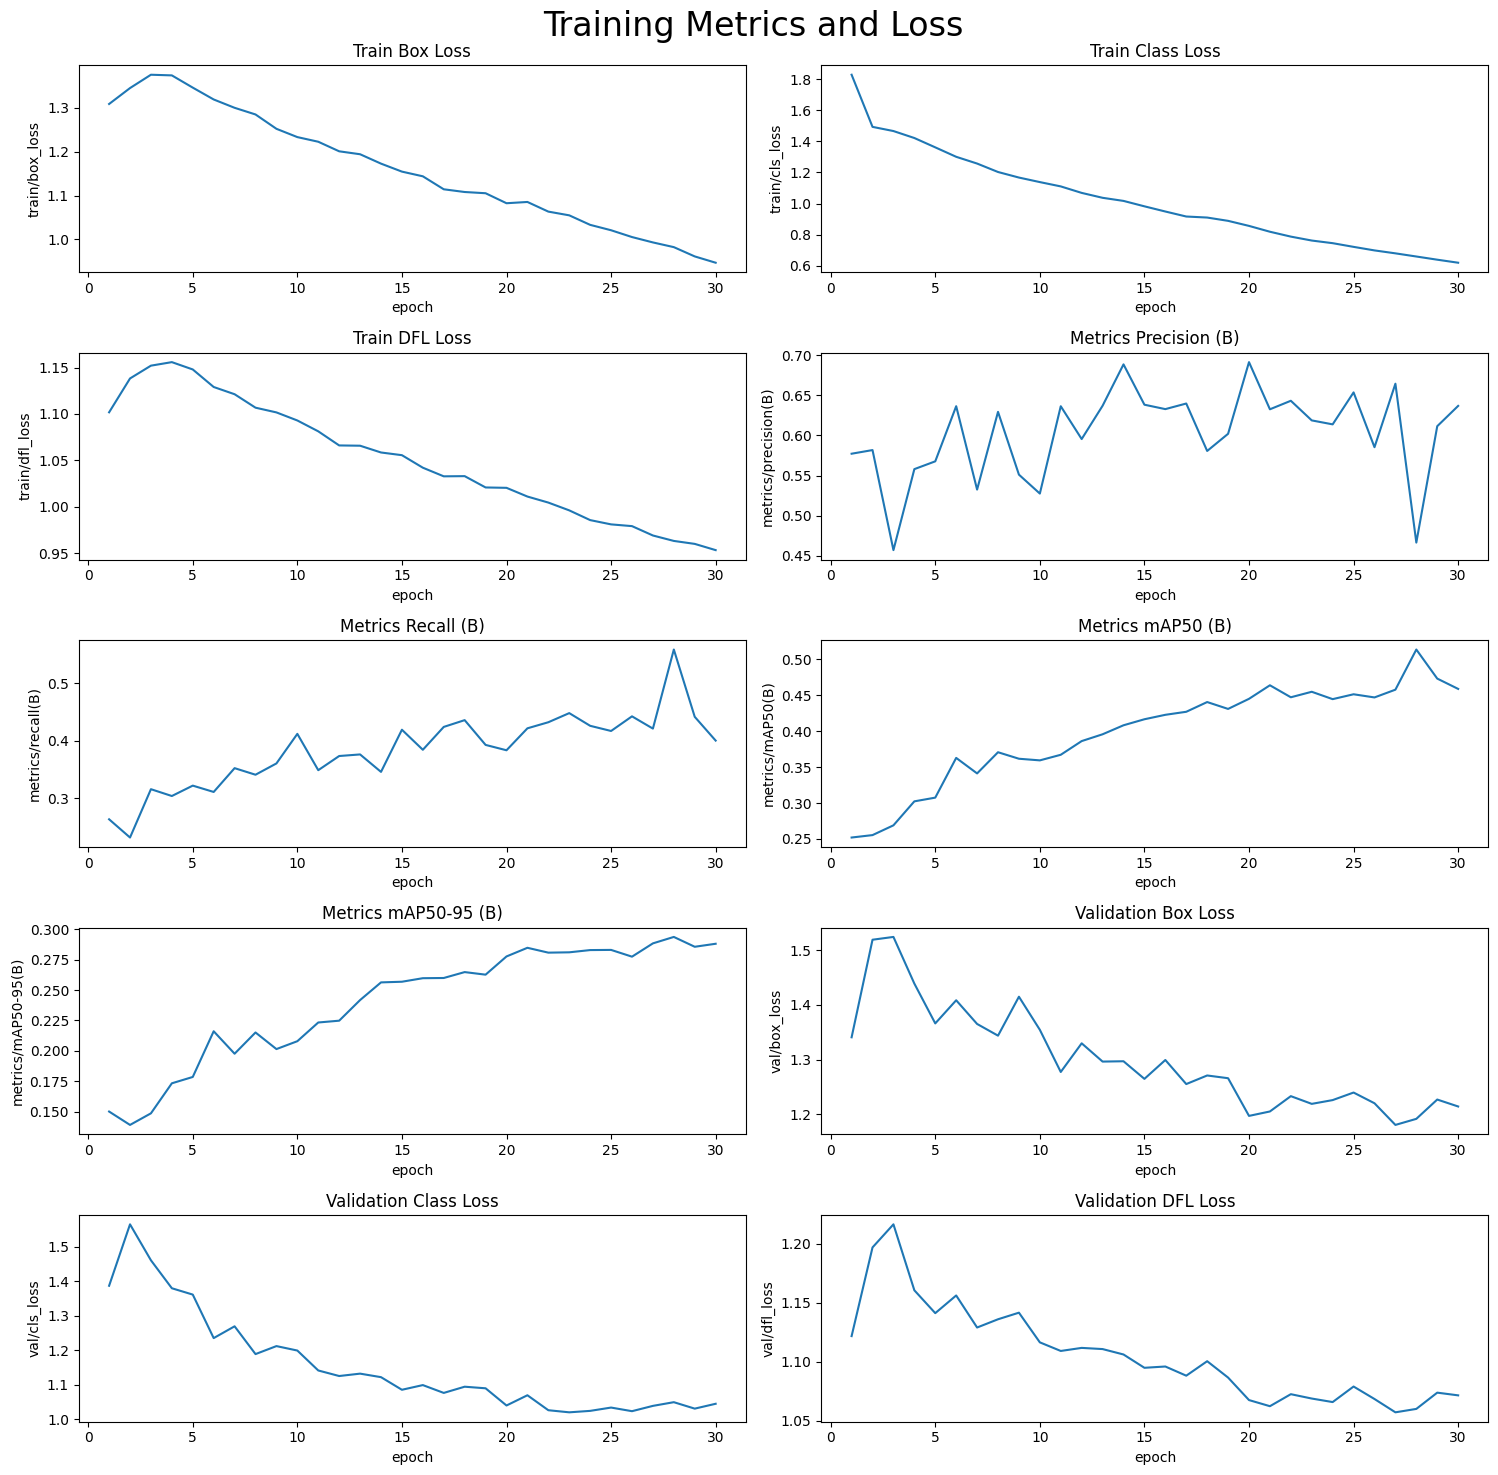

In [8]:
df = pd.read_csv('runs/detect/train/results.csv')
df.columns = df.columns.str.strip()

# create subplots using seaborn
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(15, 15))

# plot the columns using seaborn
sns.lineplot(x='epoch', y='train/box_loss', data=df, ax=axs[0,0])
sns.lineplot(x='epoch', y='train/cls_loss', data=df, ax=axs[0,1])
sns.lineplot(x='epoch', y='train/dfl_loss', data=df, ax=axs[1,0])
sns.lineplot(x='epoch', y='metrics/precision(B)', data=df, ax=axs[1,1])
sns.lineplot(x='epoch', y='metrics/recall(B)', data=df, ax=axs[2,0])
sns.lineplot(x='epoch', y='metrics/mAP50(B)', data=df, ax=axs[2,1])
sns.lineplot(x='epoch', y='metrics/mAP50-95(B)', data=df, ax=axs[3,0])
sns.lineplot(x='epoch', y='val/box_loss', data=df, ax=axs[3,1])
sns.lineplot(x='epoch', y='val/cls_loss', data=df, ax=axs[4,0])
sns.lineplot(x='epoch', y='val/dfl_loss', data=df, ax=axs[4,1])

# set titles and axis labels for each subplot
axs[0,0].set(title='Train Box Loss')
axs[0,1].set(title='Train Class Loss')
axs[1,0].set(title='Train DFL Loss')
axs[1,1].set(title='Metrics Precision (B)')
axs[2,0].set(title='Metrics Recall (B)')
axs[2,1].set(title='Metrics mAP50 (B)')
axs[3,0].set(title='Metrics mAP50-95 (B)')
axs[3,1].set(title='Validation Box Loss')
axs[4,0].set(title='Validation Class Loss')
axs[4,1].set(title='Validation DFL Loss')

# add suptitle and subheader
plt.suptitle('Training Metrics and Loss', fontsize=24)

# adjust top margin to make space for suptitle
plt.subplots_adjust(top=0.8)

# adjust spacing between subplots
plt.tight_layout()

plt.show();

### Confussion Matrix

<div align="center">
  <img src="runs\detect\train\confusion_matrix_normalized.png">
</div>

In [6]:
from ultralytics import YOLO

model1 = YOLO("yolov5xu")
print(f"sebelum : {model1.names}")
print("\n")
model2 = YOLO("runs/detect/train/weights/best.pt")
print(f"sesudah : {model2.names}")

sebelum : {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted plant', 59: 'bed', 60: 'dining table', 61: 'toilet', 62: 'tv', 63: 'laptop', 64: 'mouse', 65: 'remote', 66: 'keyboard', 67: 'cell phone', 6

# Penerapan Projek

## Penerapan Model #1

### Source Code

In [ ]:
from ultralytics import YOLO
from ultralytics.solutions import object_counter
import cv2

model = YOLO("runs/detect/train/weights/best.pt")
cap = cv2.VideoCapture("asset_penerapan/source/video_1.mp4")
assert cap.isOpened(), "Error reading video file"
w, h, fps = (
    int(cap.get(x))
    for x in (cv2.CAP_PROP_FRAME_WIDTH, cv2.CAP_PROP_FRAME_HEIGHT, cv2.CAP_PROP_FPS)
)

# Define region points
region_points = [(0, 320), (1280, 320), (1280, 400), (0, 400)]

# Video writer
video_writer = cv2.VideoWriter(
    "asset_penerapan/result/penerapan_model_1.mp4", cv2.VideoWriter_fourcc(*"mp4v"), fps, (w, h)
)

# Init Object Counter
counter = object_counter.ObjectCounter()
counter.set_args(
    view_img=True, reg_pts=region_points, classes_names=model.names, draw_tracks=True
)

while cap.isOpened():
    success, im0 = cap.read()
    if not success:
        print(
            "Video frame is empty or video processing has been successfully completed."
        )
        break
    tracks = model.track(im0, persist=True, show=False, classes=[2,3,5,7])

    im0 = counter.start_counting(im0, tracks)
    video_writer.write(im0)

cap.release()
video_writer.release()
cv2.destroyAllWindows()

### Logic Code
#### Misal kotak ini merepresentasikan 1 frame dalam video/foto yang akan di predict sebagai berikut.<br><br>
<div align="center">
  <img height=500 height=auto src="asset\Logic Code 1\0_blank_.png">
</div>

#### 0.Inisiasi Variable untuk Predict 
```python
    def extract_and_process_tracks(self, tracks):
        boxes = tracks[0].boxes.xyxy.cpu()
        clss = tracks[0].boxes.cls.cpu().tolist()
        track_ids = tracks[0].boxes.id.int().cpu().tolist()
```

#### 1. Gambar counting box

    Menambahkan counting box berdasarkan koordinat tiap sudut kotak pada frame. <br>
    Memakai library bawaan ultralystic.<br>
```python
    from ultralytics.utils.plotting import Annotator
    region_points = [(0, 320), (1280, 320), (1280, 400), (0, 400)]
    # menggambar regionnya
    self.annotator = Annotator(self.im0, self.tf, self.names)
    self.annotator.draw_region(reg_pts=self.reg_pts, color=self.region_color, thickness=self.region_thickness)
``` 
<div align="center">
  <img height=500 height=auto src="asset\Logic Code 1\1_counting_box.png">
</div>

#### 2. Gambar bounding box (Kotak disekitar object yang terpredict)

  Menggunakan library bawaan ultralystic.
```python
    from ultralytics.utils.plotting import Annotator

    self.annotator = Annotator(self.im0, self.tf, self.names)
    
    for box, track_id, cls in zip(boxes, track_ids, clss):
      self.annotator.box_label(box, label=f"{track_id}:{self.names[cls]}", color=colors(int(cls), True))
```

<div align="center">
  <img height=500 height=auto src="asset\Logic Code 1\2_bounding_box.png">
</div>

#### 3. Gambar track (titik ditengah object)
```python
    track_history = defaultdict(list) # dictionary yang dapat menspesifikan nilai untuk sesuatu yang belum ada

    for box, track_id, cls in zip(boxes, track_ids, clss):
      track_line = self.track_history[track_id]
      # menaruh track ditengah
      track_line.append((float((box[0] + box[2]) / 2), float((box[1] + box[3]) / 2)))
      # memberi kondisi untuk membatasi panjacng track yang disimpan dalam track_history
      if len(track_line) > 30:
        track_line.pop(0)
```
<div align="center">
  <img height=500 height=auto src="asset\Logic Code 1\3_track.png">
</div>

#### 4. Gambar track trails (ekor yang ngikutin titik track)
    Memakai library bawaan ultralystic.
```python
    from ultralytics.utils.plotting import Annotator

    for box, track_id, cls in zip(boxes, track_ids, clss):
        if self.draw_tracks: #kondisi mau nambilin track atau tidak
            self.annotator.draw_centroid_and_tracks(
                track_line, color=self.track_color, track_thickness=self.track_thickness
            )
```
<p align="center">
  <img height=500 height=auto src="asset\Logic Code 1\4_track_trails.png">
</p>

#### 5. Hitung object (untuk region point)
```python
for box, track_id, cls in zip(boxes, track_ids, clss):
    # inisiasi posisi sebelum
    # ngecek elemen kedua sampe terakhir kalau terdapat lebih dari 1 elemen maka prev_position ada valuenya selain itu bakal None value
    prev_position = self.track_history[track_id][-2] if len(self.track_history[track_id]) > 1 else None

    # ngasih kondisi gimana untuk mulai ngitung
    # kondisinya klo ada prev_position dan posisi terakhir track_line masuk ke counting region dan track_id belum pernah keitung sebelumnya
    if (
        prev_position is not None
        and self.counting_region.contains(Point(track_line[-1]))
        and track_id not in self.counting_list
    ):
    # menghitung
    """
    # jika selisih koordinat pojok kiri bawah box object dan prev_position memiliki tanda yang sama dengan 
    # selisih koordinat centroid counting_region dan prev_position maka itu termasuk gerakan masuk,
    # selain itu adalah keluar.
    """
        self.counting_list.append(track_id)
        if (box[0] - prev_position[0]) * (self.counting_region.centroid.x - prev_position[0]) > 0:
            self.in_counts += 1
        else:
            self.out_counts += 1
```
<div align="center">
  <img height=500 height=auto src="asset\Logic Code 1\5_counting.png">
</div>

### Demo #1.1

Menggunakan dataset pada notebook ini.

<div align="center">
<video controls src="asset_penerapan\compress\penerapan_model_1_C.mp4">
</video>
</div>

### Demo #1.2

Menggunakan pretrained model YOLOv5xu

<div align="center">
<video controls src="asset_penerapan\compress\cheat_model_1_C.mp4">
</video>
</div>

## Penerapan Model #2

### Source Code

In [ ]:
# Ultralytics YOLO 🚀, AGPL-3.0 license
from collections import defaultdict
from pathlib import Path

import cv2
import numpy as np
from shapely.geometry import Polygon
from shapely.geometry.point import Point

from ultralytics import YOLO
from ultralytics.utils.files import increment_path
from ultralytics.utils.plotting import Annotator, colors

track_history = defaultdict(list)

weights="runs/detect/train/weights/best.pt"
source="asset_penerapan/source/video_2.mp4"
output="asset_penerapan/result/penerapan_model_2.mp4"
device="0"

current_region = None
counting_regions = [
    {
        "name": "YOLOv8 Rectangle Region",
        "polygon": Polygon([(392, 330), (776, 131), (1138, 163), (1141, 405), (789, 474)]),  # Polygon points
        "counts": 0,
        "dragging": False,
        "region_color": (255, 0, 225),  # BGR Value
        "text_color": (0, 0, 0),  # Region Text Color
    },
    {
        "name": "YOLOv8 Rectangle Region",
        "polygon": Polygon([(51, 579), (308, 351), (178, 292), (22, 376)]),  # Polygon points
        "counts": 0,
        "dragging": False,
        "region_color": (255, 0, 225),  # BGR Value
        "text_color": (0, 0, 0),  # Region Text Color
    },
]


def mouse_callback(event, x, y, flags, param):
    global current_region

    # Mouse left button down event
    if event == cv2.EVENT_LBUTTONDOWN:
        for region in counting_regions:
            if region["polygon"].contains(Point((x, y))):
                current_region = region
                current_region["dragging"] = True
                current_region["offset_x"] = x
                current_region["offset_y"] = y

    # Mouse move event
    elif event == cv2.EVENT_MOUSEMOVE:
        if current_region is not None and current_region["dragging"]:
            dx = x - current_region["offset_x"]
            dy = y - current_region["offset_y"]
            current_region["polygon"] = Polygon(
                [(p[0] + dx, p[1] + dy) for p in current_region["polygon"].exterior.coords]
            )
            current_region["offset_x"] = x
            current_region["offset_y"] = y

    # Mouse left button up event
    elif event == cv2.EVENT_LBUTTONUP:
        if current_region is not None and current_region["dragging"]:
            current_region["dragging"] = False


def run(
    weights=weights,
    source=source,
    output=output,
    device=device,
    view_img=True,
    save_img=True,
    classes=None,
    line_thickness=2,
    track_thickness=2,
    region_thickness=4,
):
    vid_frame_count = 0

    # Check source path
    if not Path(source).exists():
        raise FileNotFoundError(f"Source path '{source}' does not exist.")

    # Setup Model
    model = YOLO(f"{weights}")
    model.to("cuda") if device == "0" else model.to("cpu")

    # Extract classes names
    names = model.model.names

    # Video setup
    videocapture = cv2.VideoCapture(source)
    frame_width, frame_height = int(videocapture.get(3)), int(videocapture.get(4))
    fps, fourcc = int(videocapture.get(5)), cv2.VideoWriter_fourcc(*"mp4v")

    # Output setup
    video_writer = cv2.VideoWriter(output, fourcc, fps, (frame_width, frame_height))

    # Iterate over video frames
    while videocapture.isOpened():
        success, frame = videocapture.read()
        if not success:
            break
        vid_frame_count += 1

        # Extract the results
        results = model.track(frame, persist=True, classes=classes)

        if results[0].boxes.id is not None:
            boxes = results[0].boxes.xyxy.cpu()
            track_ids = results[0].boxes.id.int().cpu().tolist()
            clss = results[0].boxes.cls.cpu().tolist()

            annotator = Annotator(frame, line_width=line_thickness, example=str(names))

            for box, track_id, cls in zip(boxes, track_ids, clss):
                annotator.box_label(box, str(names[cls]), color=colors(cls, True))
                bbox_center = (box[0] + box[2]) / 2, (box[1] + box[3]) / 2  # Bbox center

                track = track_history[track_id]  # Tracking Lines plot
                track.append((float(bbox_center[0]), float(bbox_center[1])))
                if len(track) > 30:
                    track.pop(0)
                points = np.hstack(track).astype(np.int32).reshape((-1, 1, 2))
                cv2.polylines(frame, [points], isClosed=False, color=colors(cls, True), thickness=track_thickness)

                # Check if detection inside region
                for region in counting_regions:
                    if region["polygon"].contains(Point((bbox_center[0], bbox_center[1]))):
                        region["counts"] += 1

        # Draw regions (Polygons/Rectangles)
        for region in counting_regions:
            region_label = str(region["counts"])
            region_color = region["region_color"]
            region_text_color = region["text_color"]

            polygon_coords = np.array(region["polygon"].exterior.coords, dtype=np.int32)
            centroid_x, centroid_y = int(region["polygon"].centroid.x), int(region["polygon"].centroid.y)

            text_size, _ = cv2.getTextSize(
                region_label, cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.7, thickness=line_thickness
            )
            text_x = centroid_x - text_size[0] // 2
            text_y = centroid_y + text_size[1] // 2
            cv2.rectangle(
                frame,
                (text_x - 5, text_y - text_size[1] - 5),
                (text_x + text_size[0] + 5, text_y + 5),
                region_color,
                -1,
            )
            cv2.putText(
                frame, region_label, (text_x, text_y), cv2.FONT_HERSHEY_SIMPLEX, 0.7, region_text_color, line_thickness
            )
            cv2.polylines(frame, [polygon_coords], isClosed=True, color=region_color, thickness=region_thickness)

        if view_img:
            if vid_frame_count == 1:
                cv2.namedWindow("Ultralytics YOLOv8 Region Counter Movable")
                cv2.setMouseCallback("Ultralytics YOLOv8 Region Counter Movable", mouse_callback)
            cv2.imshow("Ultralytics YOLOv8 Region Counter Movable", frame)

        if save_img:
            video_writer.write(frame)

        for region in counting_regions:  # Reinitialize count for each region
            region["counts"] = 0

        if cv2.waitKey(1) & 0xFF == ord("q"):
            break

    del vid_frame_count
    video_writer.release()
    videocapture.release()
    cv2.destroyAllWindows()

if __name__ == "__main__":
    run()


### Logic Code

Sama persis seperti di Model #1, hanya berbeda di kondisi menghitungnya.
Alih-alih menghitung kalau ada prev_position dan posisi terakhir track_line masuk ke counting region dan track_id belum pernah keitung sebelumnya. 
Pada model ini akan menghitung jumlah center yang terdapat di dalam counting box

```python
bbox_center = (box[0] + box[2]) / 2, (box[1] + box[3]) / 2  # Bbox center
for region in counting_regions:
    if region["polygon"].contains(Point((bbox_center[0], bbox_center[1]))):
        region["counts"] += 1
```


### Demo #2.1

Menggunakan dataset pada notebook ini.

<div align="center">
<video controls src="asset_penerapan\compress\penerapan_model_2_C.mp4">
</video>
</div>

### Demo #2.2

Menggunakan dataset https://universe.roboflow.com/dmay/cctv_car_bike_detection-jzjis/dataset/3 <br>
yang ditrain menggunakan model YOLOv8m dengan parameter : <br>
```python
model.train(data='cctv_car_bike_detection-3\data.yaml',
            epochs=30,
            imgsz=h,
            seed=42,
            batch=8,
            workers=4)
```

<div align="center">
<video controls src="asset_penerapan\compress\cheat_model_2_C.mp4">
</video>
</div>

## Penerapan Model #3

### Source Code

In [ ]:
# Terlalu panjang, silahkan cek source/penerapan_model_3.py

### Logic Code

Gabungan dari Penerapan Model #1 dan penerapan Model #2

### Demo #3.1

Menggunakan dataset pada notebook ini.

<div align="center">
<video controls src="asset_penerapan\compress\penerapan_model_3_C.mp4">
</video>
</div>

### Demo #3.2

Menggunakan dataset https://universe.roboflow.com/video-3/video-3-pz2bw/dataset/1 <br>
yang ditrain menggunakan model YOLOv8m dengan parameter : <br>
```python
model.train(data='video-3-1/data.yaml',
            epochs=60,
            imgsz=640,
            seed=42,
            batch=8,
            workers=4)
```

<div align="center">
<video controls src="asset_penerapan\compress\cheat_model_3_C.mp4">
</video>
</div>